Implement deotte: https://www.kaggle.com/competitions/map-charting-student-math-misunderstandings/discussion/589452

LLM training: https://www.kaggle.com/competitions/map-charting-student-math-misunderstandings/discussion/598250

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c map-charting-student-math-misunderstandings
!unzip /content/map-charting-student-math-misunderstandings.zip
!rm /content/map-charting-student-math-misunderstandings.zip

Mounted at /content/drive
  0% 0.00/815k [00:00<?, ?B/s]
100% 815k/815k [00:00<00:00, 793MB/s]
Archive:  /content/map-charting-student-math-misunderstandings.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# ## Get Deberta model
# from transformers import AutoTokenizer, AutoModel

# model_name = "microsoft/deberta-v3-xsmall"  # official HF hub model

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [4]:
# # For Kaggle Version
# !pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3

# import kagglehub
# import torch
# from transformers.models.gemma3 import Gemma3ForConditionalGeneration, Gemma3Processor

# GEMMA_PATH = kagglehub.model_download("google/gemma-3/transformers/gemma-3-270m-it")
# processor = Gemma3Processor.from_pretrained(GEMMA_PATH)
# model = Gemma3ForConditionalGeneration.from_pretrained(GEMMA_PATH, torch_dtype=torch.float16).to(device)
# print(model)

In [7]:
## Get Gemma3 270M model
from google.colab import userdata
from huggingface_hub import login

# Get your secret
hf_token = userdata.get('gemma3')

# Login to Hugging Face
login(token=hf_token)

from transformers import AutoTokenizer, AutoModel

model_name = "google/gemma-3-270m"  # official HF hub model

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some weights of Gemma3TextModel were not initialized from the model checkpoint at google/gemma-3-270m and are newly initialized: ['embed_tokens.weight', 'layers.0.input_layernorm.weight', 'layers.0.mlp.down_proj.weight', 'layers.0.mlp.gate_proj.weight', 'layers.0.mlp.up_proj.weight', 'layers.0.post_attention_layernorm.weight', 'layers.0.post_feedforward_layernorm.weight', 'layers.0.pre_feedforward_layernorm.weight', 'layers.0.self_attn.k_norm.weight', 'layers.0.self_attn.k_proj.weight', 'layers.0.self_attn.o_proj.weight', 'layers.0.self_attn.q_norm.weight', 'layers.0.self_attn.q_proj.weight', 'layers.0.self_attn.v_proj.weight', 'layers.1.input_layernorm.weight', 'layers.1.mlp.down_proj.weight', 'layers.1.mlp.gate_proj.weight', 'layers.1.mlp.up_proj.weight', 'layers.1.post_attention_layernorm.weight', 'layers.1.post_feedforward_layernorm.weight', 'layers.1.pre_feedforward_layernorm.weight', 'layers.1.self_attn.k_norm.weight', 'layers.1.self_attn.k_proj.weight', 'layers.1.self_attn.o_pro

In [ ]:
# %%capture
# !pip install optuna

## Import Packages

In [8]:
# --- Standard Library ---
import re

# --- Data Science / Numerics ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# --- Scikit-learn ---
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    roc_auc_score,
    classification_report,
    accuracy_score,
    log_loss,
    confusion_matrix
)
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Gradient Boosting / Tree Models ---
import xgboost as xgb

# --- Deep Learning (TensorFlow / Keras) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models
# from keras_tuner import HyperModel, RandomSearch

# --- Deep Learning (PyTorch / Transformers) ---
import torch
from transformers import (
    DebertaTokenizer,
    DebertaForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset

# --- NLP / Text Processing ---
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('wordnet')

from transformers import AutoModelForCausalLM, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Load Data

In [9]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

In [ ]:
train.shape, test.shape, sub.shape

((36696, 7), (3, 5), (3, 2))

In [ ]:
train.head()

,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
row_id,,,,,,
0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN
2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NaN
3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NaN
4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NaN


In [ ]:
test.head()

,QuestionId,QuestionText,MC_Answer,StudentExplanation
row_id,,,,
36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si..."
36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...
36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.


## Data Preprocessing

In [ ]:
def advanced_clean(text):
    text = re.sub(r'(\d+)\s*/\s*(\d+)', r'FRAC_\1_\2', text)
    text = re.sub(r'\\frac\{([^}]+)\}\{([^}]+)\}', r'FRAC_\1_\2', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s_]', '', text)
    return text.strip().lower()

def extract_math_features(text):
    return {
        'frac_count': len(re.findall(r'FRAC_\d+_\d+|\\frac', text)),
        'number_count': len(re.findall(r'\b\d+\b', text)),
        'operator_count': len(re.findall(r'[\+\-\*/=]', text)),
        'starts_with_number': int(bool(re.match(r'^\d+', text))),
        'has_frac_token': int('FRAC_' in text)
    }

def extract_math_features(text):
    return {
        'frac_count': len(re.findall(r'FRAC_\d+_\d+|\\frac', text)),
        'number_count': len(re.findall(r'\b\d+\b', text)),
        'operator_count': len(re.findall(r'[\+\-\*/=]', text)),
        'starts_with_number': int(bool(re.match(r'^\d+', text))),
        'has_frac_token': int('FRAC_' in text)
    }

def fast_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

def more_math_feats(text):
    return {
        'starts_with_frac': int(text.startswith('FRAC_')),
        'contains_eq': int('=' in text)
    }

def create_features(df):
    df['mc_answer_len'] = df['MC_Answer'].astype(str).str.len()
    df['explanation_len'] = df['StudentExplanation'].astype(str).str.len()
    df['question_len'] = df['QuestionText'].astype(str).str.len()
    df['explanation_to_question_ratio'] = df['explanation_len'] / (df['question_len'] + 1)

    for col in ['QuestionText', 'MC_Answer', 'StudentExplanation']:
        tokens = df[col].astype(str).apply(advanced_clean).apply(fast_lemmatize).str.split()
        df[f'{col}_tok_count'] = tokens.apply(len)
        df[f'{col}_uniq_ratio'] = tokens.apply(lambda x: len(set(x)) / (len(x) + 1))

        feats = pd.DataFrame(df[col].astype(str).apply(more_math_feats).tolist())
        feats.columns = [f'{col.lower()}_{c}' for c in feats.columns]
        df = pd.concat([df, feats], axis=1)

    for col in ['QuestionText', 'MC_Answer']:
        features = df[col].astype(str).apply(advanced_clean).apply(extract_math_features).apply(pd.Series)
        prefix = 'mc_' if col == 'MC_Answer' else ''
        features.columns = [f'{prefix}{c}' for c in features.columns]
        df = pd.concat([df, features], axis=1)

    df['answer_to_question_ratio'] = df['mc_answer_len'] / (df['question_len'] + 1)
    df['explanation_to_answer_ratio'] = df['explanation_len'] / (df['mc_answer_len'] + 1)
    return df

In [ ]:
train['Misconception'] = train['Misconception'].fillna('NA').astype(str)
train['target_cat'] = train['Category'] + ':' + train['Misconception']
train = train.sort_values('target_cat').reset_index(drop=True)

In [ ]:
train['combined_text'] = "Question: " + train['QuestionText'] + " Answer: " + train['MC_Answer'] + " Explanation: " + train['StudentExplanation']
test['combined_text'] = "Question: " + test['QuestionText'] + " Answer: " + test['MC_Answer'] + " Explanation: " + test['StudentExplanation']

In [ ]:
train = create_features(train)
test = create_features(test)

In [ ]:
train['cleaned_text'] = train['combined_text'].apply(advanced_clean).apply(fast_lemmatize)
test['cleaned_text'] = test['combined_text'].apply(advanced_clean).apply(fast_lemmatize)

train['mc_cleaned'] = train['MC_Answer'].astype(str).apply(advanced_clean).apply(fast_lemmatize)
test['mc_cleaned'] = test['MC_Answer'].astype(str).apply(advanced_clean).apply(fast_lemmatize)

train['q_cleaned'] = train['QuestionText'].astype(str).apply(advanced_clean).apply(fast_lemmatize)
test['q_cleaned'] = test['QuestionText'].astype(str).apply(advanced_clean).apply(fast_lemmatize)


In [ ]:
# TF-Itrain
tfidf_word = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=2000)
tfidf_word.fit(pd.concat([train['cleaned_text'], test['cleaned_text']]))
df_word = tfidf_word.transform(train['cleaned_text'])
test_word = tfidf_word.transform(test['cleaned_text'])


tfidf_expl = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=1000)
tfidf_expl.fit(pd.concat([train['StudentExplanation'], test['StudentExplanation']]))
df_expl = tfidf_expl.transform(train['StudentExplanation'])
test_expl = tfidf_expl.transform(test['StudentExplanation'])


tfidf_mc = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
tfidf_mc.fit(pd.concat([train['mc_cleaned'], test['mc_cleaned']]))
df_mc = tfidf_mc.transform(train['mc_cleaned'])
test_mc = tfidf_mc.transform(test['mc_cleaned'])


q_vecs = tfidf_mc.transform(train['q_cleaned'])
a_vecs = tfidf_mc.transform(train['mc_cleaned'])
train['qa_cosine'] = cosine_similarity(q_vecs, a_vecs).diagonal()

q_vecs_test = tfidf_mc.transform(test['q_cleaned'])
a_vecs_test = tfidf_mc.transform(test['mc_cleaned'])
test['qa_cosine'] = cosine_similarity(q_vecs_test, a_vecs_test).diagonal()


char_tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5), max_features=1000)
char_tfidf.fit(pd.concat([train['cleaned_text'], test['cleaned_text']]))
df_char = char_tfidf.transform(train['cleaned_text'])
test_char = char_tfidf.transform(test['cleaned_text'])

In [ ]:
# # For Deberta
# le = LabelEncoder()
# train.Misconception = train.Misconception.fillna('NA')
# train['target'] = train.Category+":"+train.Misconception
# train['label'] = le.fit_transform(train['target'])
# n_classes = len(le.classes_)
# print(f"Train shape: {train.shape} with {n_classes} target classes")

Train shape: (36696, 8) with 65 target classes


### Feat Engineer

In [ ]:
# Feat engineer
idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)

In [ ]:
test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)

## EDA

### Missing Values Check

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))#[0]

In [ ]:
# Initialize a list to store data
data = []

for column in train.columns:
    data_type = str(train[column].dtype)

    # Calculate missing percentages
    train_missing = np.round(100 - train[column].count() / train.shape[0] * 100, 1)

    if column not in target:
        test_missing = np.round(100 - test[column].count() / test.shape[0] * 100, 1)
        unique_values_count_test = test[column].nunique()

        # Compute unique values in train that are NOT in test
        unique_train_values = set(train[column].dropna().unique())
        unique_test_values = set(test[column].dropna().unique())
        unseen_in_test = len( unique_test_values - unique_train_values)
        unseen_percentage = np.round((unseen_in_test / len(unique_train_values)) * 100, 2) if len(unique_train_values) > 0 else 0
    else:
        test_missing = "NA"
        unique_values_count_test = "NA"
        unseen_percentage = "NA"

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = np.round(train[column].nunique() / train.shape[0], 4)
    unique_values_count = train[column].nunique()

    # Append row to list
    data.append([column, data_type, train_missing, test_missing,
                 discrete_ratio, unique_values_count, unique_values_count_test, unseen_percentage])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',
                                         'Discrete Ratio (Train)', 'Unique Values Count Train',
                                         'Unique Values Count Test', 'Unique % Unseen in Test'])

# Display the DataFrame
df_summary


,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
0,QuestionId,int64,0.0,0.0,0.0004,15,2,0.0
1,QuestionText,object,0.0,0.0,0.0004,15,2,0.0
2,MC_Answer,object,0.0,0.0,0.0013,49,3,0.0
3,StudentExplanation,object,0.0,0.0,0.9736,35726,3,0.01
4,Category,object,0.0,NA,0.0002,6,NA,NA
5,Misconception,object,73.1,NA,0.0010,35,NA,NA


### Plots

In [ ]:
target = 'Category'
regression =  train[target].nunique() > 10

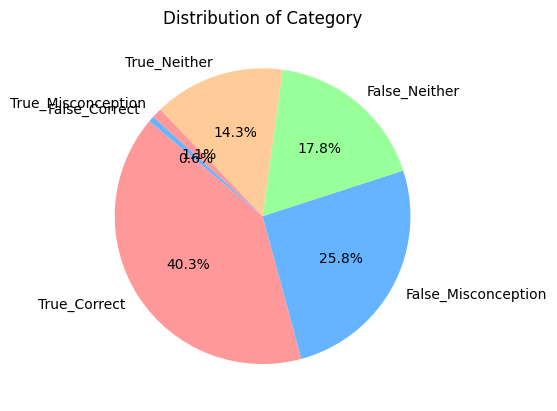

In [ ]:
if regression:
    # Histogram for continuous target
    plt.hist(train[target], bins=30, edgecolor='black', alpha=0.7, color='skyblue')

    # Calculate mean and median
    mean_value = np.mean(train[target])
    median_value = np.median(train[target])

    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

    # Add text annotations
    plt.text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
    plt.text(median_value, plt.ylim()[1] * 0.8, f'Median: {median_value:.2f}', color='green', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

    # Labels and title
    plt.xlabel(target)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {target}")
    plt.legend()

else:
    # Pie chart for categorical target
    class_counts = train[target].value_counts()
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    plt.title(f"Distribution of {target}")

plt.show()

In [ ]:
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

#### Numeric

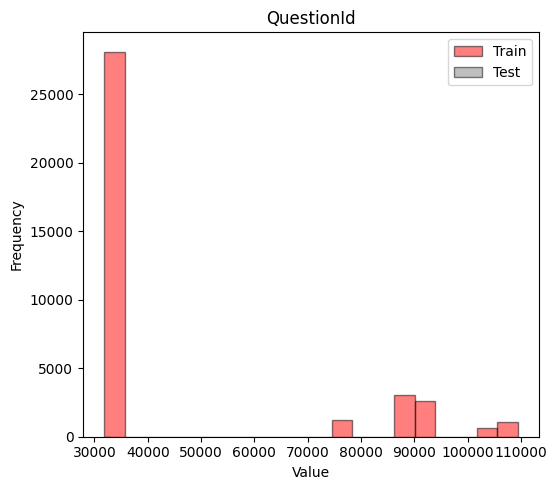

In [ ]:
# Calculate the number of rows needed for the subplots
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each continuous column and plot the histograms
for i, col in enumerate(numeric_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins = round(range_val / bin_size)

    # Plot the histograms
    axs[i].hist(train[col], bins=num_bins, color='red', alpha=0.5, label='Train', edgecolor='black')
    axs[i].hist(test[col], bins=num_bins, color='grey', alpha=0.5, label='Test', edgecolor='black')

    # Titles and labels
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

/tmp/ipython-input-3549358750.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=classes)


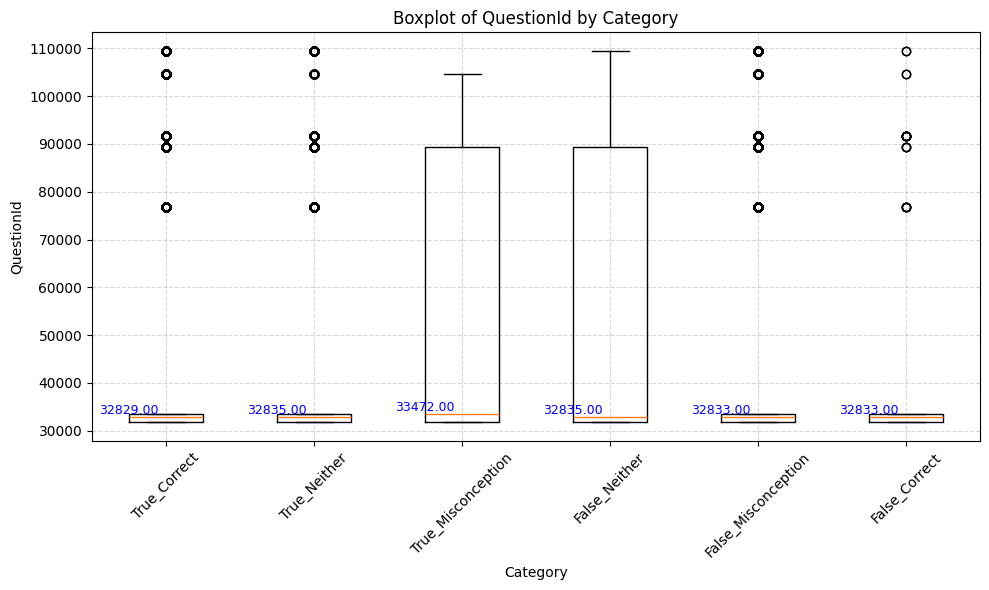

In [ ]:
if regression:
    # Determine number of rows for subplots (3 columns per row)
  num_rows = (len(numeric_cols) + 2) // 3

  # Create subplots
  fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

  # Flatten the axs array for easy iteration
  axs = axs.flatten()

  # Loop through each numeric column and plot the scatter plot
  for i, col in enumerate(numeric_cols):
      axs[i].scatter(train[col], train[target], alpha=0.5, color='blue', edgecolors='black')
      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)

  # Remove any unused subplots
  for j in range(i + 1, len(axs)):
      fig.delaxes(axs[j])

  plt.tight_layout()
  plt.show()

else:
  classes = train[target].unique()

  for col in numeric_cols:
    plt.figure(figsize=(10, 6))

    # Gather data grouped by target
    data_to_plot = [train[train[target] == tgt][col].values for tgt in classes]

    # Create boxplot and get the dictionary of plot elements
    box = plt.boxplot(data_to_plot, labels=classes)

    # Annotate the median values
    for i, median_line in enumerate(box['medians']):
        x, y = median_line.get_xdata(), median_line.get_ydata()
        median_value = y[0]  # both y[0] and y[1] are the same for a horizontal line
        plt.text(x[0], median_value, f'{median_value:.2f}',
                ha='center', va='bottom', fontsize=9, color='blue')

    plt.title(f'Boxplot of {col} by {target}')
    plt.xlabel(target)
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

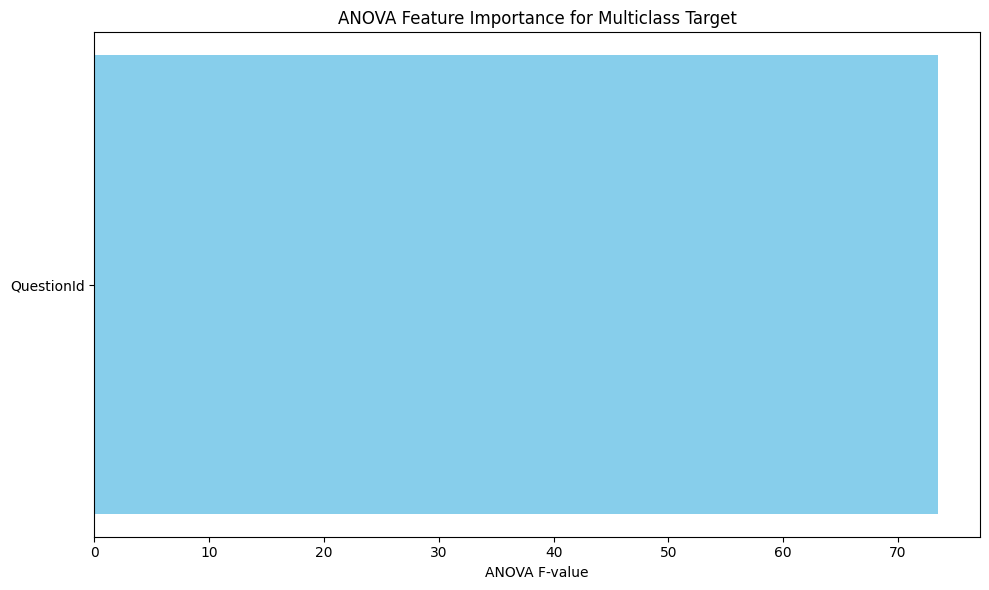

In [ ]:
if regression:
  corr = train[numeric_cols + [target]].corr()
  plt.figure(figsize = (10, 8), dpi = 300)
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True, annot_kws = {'size' : 7}, vmin = -1, vmax = 1)
  plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
  plt.show()

else:
  X = train[numeric_cols].fillna(-999)
  y = train[target]

  # Compute ANOVA F-value
  f_vals, p_vals = f_classif(X, y)

  # Create DataFrame
  anova_df = pd.DataFrame({
      'Feature': X.columns.tolist(),
      'F_value': f_vals,
      'p_value': p_vals
  }).sort_values('F_value', ascending=False)

  # Plot
  plt.figure(figsize=(10, 6))
  plt.barh(anova_df['Feature'], anova_df['F_value'], color='skyblue')
  plt.xlabel('ANOVA F-value')
  plt.title('ANOVA Feature Importance for Multiclass Target')
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

#### Categorical

/tmp/ipython-input-971012756.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


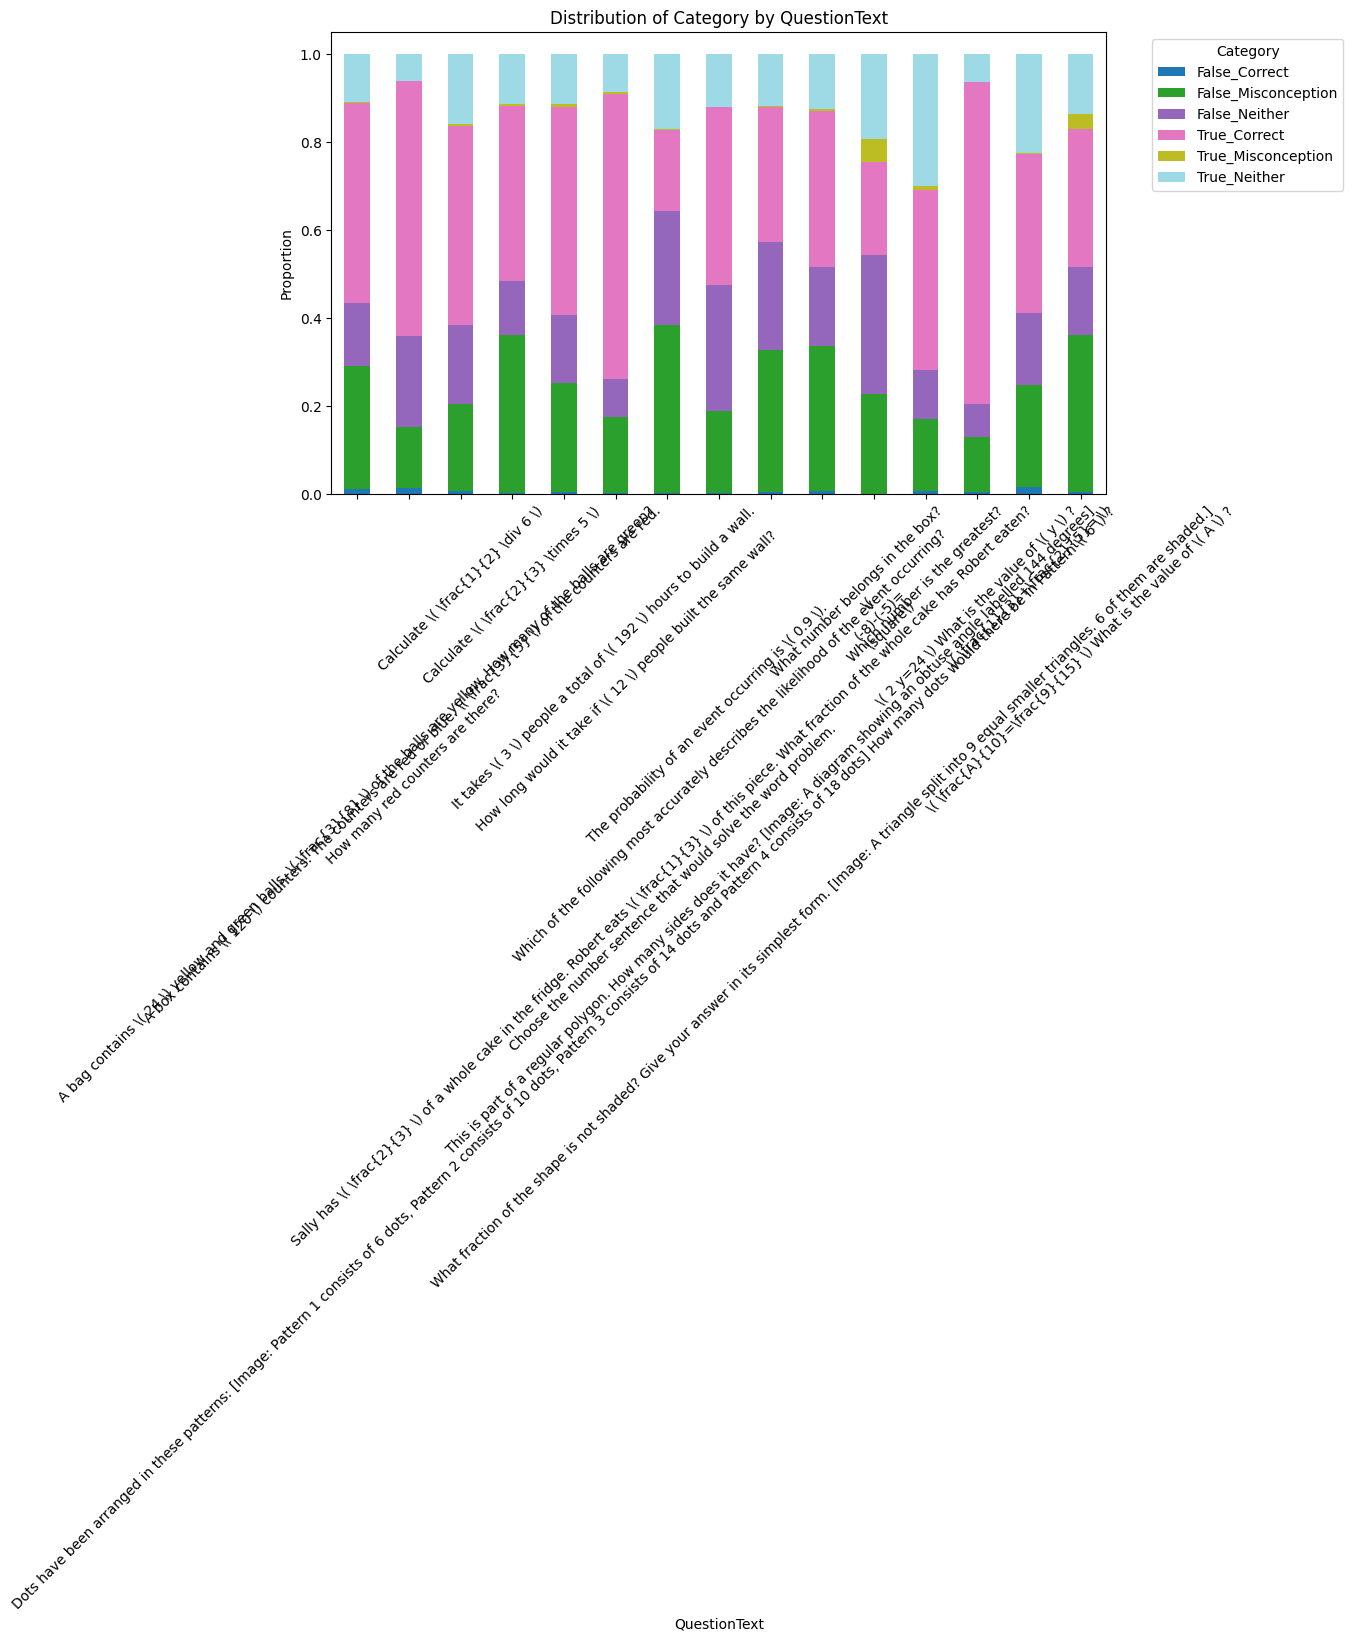

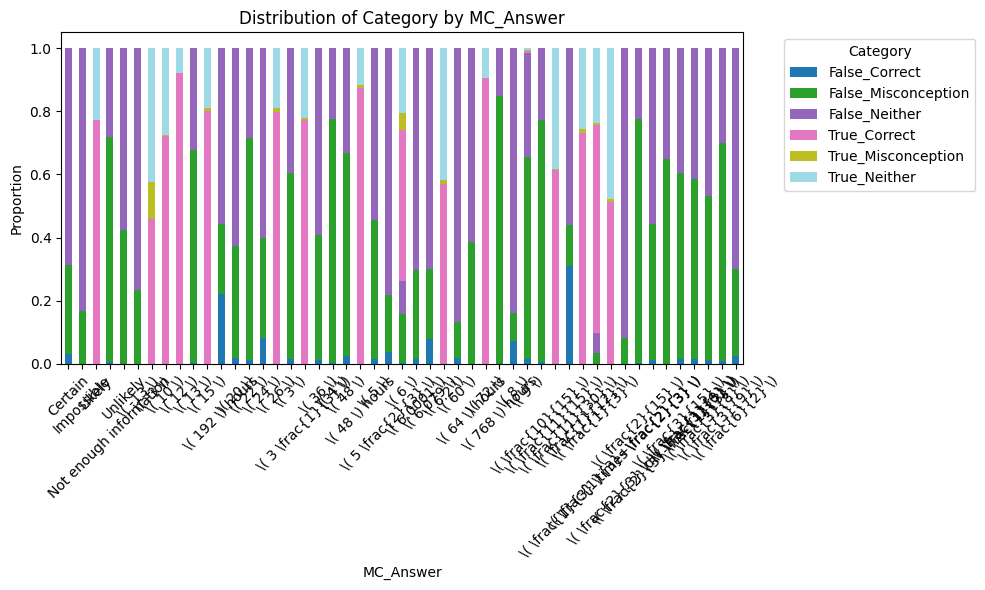

/tmp/ipython-input-971012756.py:34: UserWarning: Glyph 12387 (\N{HIRAGANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-971012756.py:34: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-971012756.py:34: UserWarning: Glyph 10135 (\N{HEAVY DIVISION SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-971012756.py:34: UserWarning: Glyph 129412 (\N{UNICORN FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-971012756.py:34: UserWarning: Glyph 128151 (\N{GROWING HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-971012756.py:34: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-971012756.py:34: UserWarning: Glyph 12290 (\N{IDEOGRAPHIC FULL STOP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-971012756.py:34: UserW

KeyboardInterrupt: 

In [ ]:
if regression:
  fig, axs = plt.subplots(len(categorical_cols), 1, figsize=(10, len(categorical_cols) * 4))

  for i, col in enumerate(categorical_cols):
      # Get the top 10 most frequent categories
      top_categories = train[col].value_counts().nlargest(10).index

      # Filter train data to only include top categories
      filtered_train = train[train[col].isin(top_categories)]

      # Create box plot
      axs[i].boxplot(
          [filtered_train[filtered_train[col] == category][target] for category in top_categories],
          labels=top_categories
      )

      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)
      axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

  plt.tight_layout()
  plt.show()

else:
  for col in categorical_cols:
    crosstab = pd.crosstab(train[col], train[target], normalize='index')  # row-wise percent
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
    plt.title(f'Distribution of {target} by {col}')
    plt.ylabel('Proportion')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
if regression:
  from scipy.stats import kruskal

  kruskal_results = {}

  for col in categorical_cols:
      groups = [train[train[col] == category][target] for category in train[col].unique()]
      if len(groups) > 1:
          stat, p = kruskal(*groups)
          kruskal_results[col] = {"Kruskal-Wallis Statistic": stat, "p-value": p}

  # Convert to DataFrame
  kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient="index")
  display(kruskal_df.sort_values(by="Kruskal-Wallis Statistic", ascending=False))

# Higher statistic → Stronger categorical effect

# Lower p-value → More significant relationship

else:
  chi2_results = {}

  # Encode the multiclass target
  y_encoded = LabelEncoder().fit_transform(train[target])

  for col in categorical_cols:
      # Encode the categorical feature
      x_encoded = LabelEncoder().fit_transform(train[col]).reshape(-1, 1)

      # Run chi-squared test
      stat, p = chi2(x_encoded, y_encoded)
      chi2_results[col] = {"Chi2 Statistic": stat[0], "p-value": p[0]}

  # Convert to DataFrame
  chi2_df = pd.DataFrame.from_dict(chi2_results, orient="index")
  display(chi2_df.sort_values(by="Chi2 Statistic", ascending=False))

,Chi2 Statistic,p-value
StudentExplanation,784884.718259,0.000000e+00
MC_Answer,8214.951410,0.000000e+00
QuestionText,1277.185570,5.596245e-274


### Unique

In [ ]:
train.groupby('QuestionId')['Category'].value_counts(normalize = True)

QuestionId  Category           
31772       True_Correct           0.353922
            False_Misconception    0.330451
            False_Neither          0.179741
            True_Neither           0.126210
            False_Correct          0.006383
                                     ...   
109465      True_Correct           0.406280
            False_Neither          0.284491
            False_Misconception    0.187441
            True_Neither           0.119886
            False_Correct          0.001903
Name: proportion, Length: 88, dtype: float64

In [ ]:
train['Misconception'].unique()

array([nan, 'Incomplete', 'WNB', 'SwapDividend', 'Mult', 'FlipChange',
       'Irrelevant', 'Wrong_Fraction', 'Additive', 'Not_variable',
       'Adding_terms', 'Inverse_operation', 'Inversion', 'Duplication',
       'Wrong_Operation', 'Whole_numbers_larger', 'Longer_is_bigger',
       'Ignores_zeroes', 'Shorter_is_bigger', 'Wrong_fraction',
       'Adding_across', 'Denominator-only_change',
       'Incorrect_equivalent_fraction_addition', 'Division',
       'Subtraction', 'Unknowable', 'Definition', 'Interior', 'Positive',
       'Tacking', 'Wrong_term', 'Firstterm', 'Base_rate',
       'Multiplying_by_4', 'Certainty', 'Scale'], dtype=object)

In [ ]:
train['Misconception'].value_counts()

,count
Misconception,
Incomplete,1454
Additive,929
Duplication,704
Subtraction,620
Positive,566
Wrong_term,558
Irrelevant,497
Wrong_fraction,418
Inversion,414


In [ ]:
train.dropna().groupby('QuestionId')['Misconception'].value_counts()

QuestionId  Misconception                         
31772       Incomplete                                1359
            WNB                                        262
31774       Mult                                       353
            SwapDividend                               206
            FlipChange                                  78
31777       Wrong_Fraction                             273
            Incomplete                                  76
            Irrelevant                                  41
31778       Additive                                   929
            Irrelevant                                 456
            WNB                                         37
32829       Not_variable                               154
            Adding_terms                                97
            Inverse_operation                           21
32833       Duplication                                704
            Inversion                                  414
            Wrong_Operation                              6
32835       Whole_numbers_larger                       329
            Longer_is_bigger                            24
            Ignores_zeroes                              23
            Shorter_is_bigger                           23
33471       Wrong_fraction                             418
            Incomplete                                  19
33472       Denominator-only_change                    336
            Adding_across                              307
            Incorrect_equivalent_fraction_addition       9
33474       Subtraction                                620
            Division                                    63
76870       Unknowable                                 282
            Definition                                  54
            Interior                                    50
89443       Positive                                   566
            Tacking                                    290
91695       Wrong_term                                 558
            Firstterm                                  107
104665      Multiplying_by_4                            96
            Base_rate                                   23
109465      Scale                                      179
            Certainty                                   18
Name: count, dtype: int64

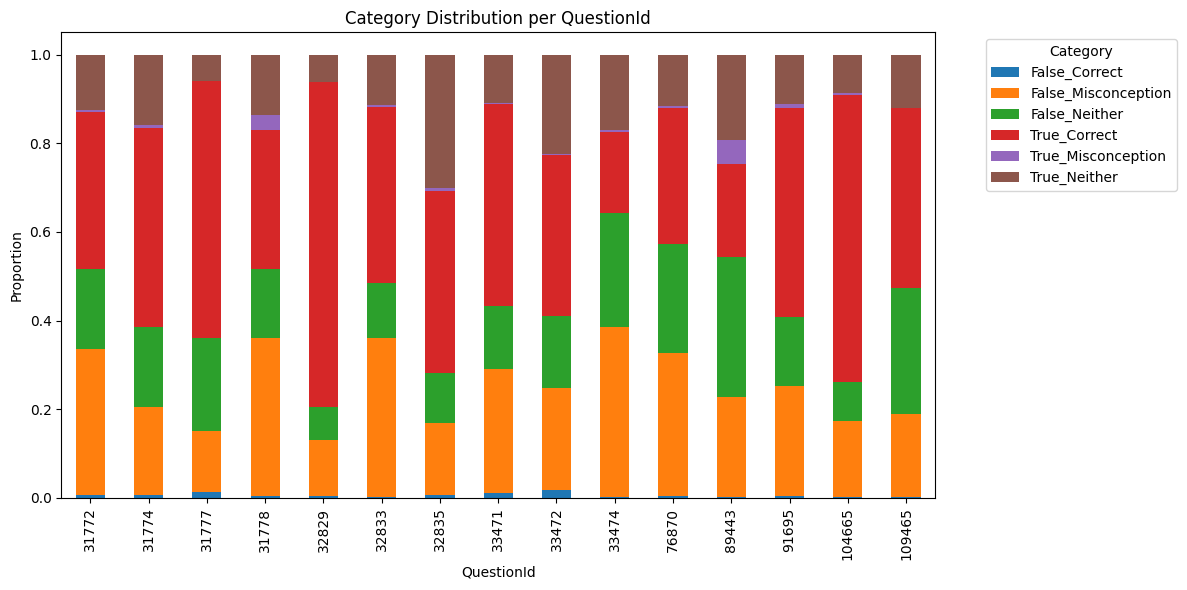

In [ ]:
# Your grouped proportions
proportions = train.groupby('QuestionId')['Category'].value_counts(normalize=True)

# Convert to a DataFrame
proportions = proportions.rename("proportion").reset_index()

# Pivot to make categories columns
pivot_df = proportions.pivot(index="QuestionId", columns="Category", values="proportion")

# Plot stacked bar chart
ax = pivot_df.plot(kind="bar", stacked=True, figsize=(12,6))

plt.title("Category Distribution per QuestionId")
plt.ylabel("Proportion")
plt.xlabel("QuestionId")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import display, Math, Latex

# GET ANSWER CHOICES
tmp = train.groupby(['QuestionId','MC_Answer']).size().reset_index(name='count')
tmp['rank'] = tmp.groupby('QuestionId')['count'].rank(method='dense', ascending=False).astype(int) - 1
tmp = tmp.drop('count',axis=1)
tmp = tmp.sort_values(['QuestionId','rank'])

# DISPLAY QUESTION AND ANSWER CHOICES
Q = tmp.QuestionId.unique()
for q in Q:
    question = train.loc[train.QuestionId==q].iloc[0].QuestionText
    choices = tmp.loc[tmp.QuestionId==q].MC_Answer.values
    labels="ABCD"
    choice_str = " ".join([f"({labels[i]}) {choice}" for i, choice in enumerate(choices)])

    print()
    display(f"QuestionId {q}: {question}" )
    display(f"MC Answers: {choice_str}")

'QuestionId 31772: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]'

'MC Answers: (A) \\( \\frac{1}{3} \\) (B) \\( \\frac{3}{9} \\) (C) \\( \\frac{3}{6} \\) (D) \\( \\frac{3}{8} \\)'

'QuestionId 31774: Calculate \\( \\frac{1}{2} \\div 6 \\)'

'MC Answers: (A) \\( \\frac{1}{12} \\) (B) \\( 3 \\) (C) \\( \\frac{6}{2} \\) (D) \\( \\frac{1}{3} \\)'

'QuestionId 31777: A box contains \\( 120 \\) counters. The counters are red or blue. \\( \\frac{3}{5} \\) of the counters are red.\nHow many red counters are there?'

'MC Answers: (A) \\( 72 \\) (B) \\( 48 \\) (C) \\( 60 \\) (D) \\( 24 \\)'

'QuestionId 31778: \\( \\frac{A}{10}=\\frac{9}{15} \\) What is the value of \\( A \\) ?'

'MC Answers: (A) \\( 6 \\) (B) \\( 4 \\) (C) \\( 3 \\) (D) \\( 9 \\)'

'QuestionId 32829: \\( 2 y=24 \\) What is the value of \\( y \\) ?'

'MC Answers: (A) \\( 12 \\) (B) \\( 4 \\) (C) \\( 22 \\) (D) \\( 48 \\)'

'QuestionId 32833: Calculate \\( \\frac{2}{3} \\times 5 \\)'

'MC Answers: (A) \\( 3 \\frac{1}{3} \\) (B) \\( \\frac{10}{15} \\) (C) \\( \\frac{2}{15} \\) (D) \\( 5 \\frac{2}{3} \\)'

'QuestionId 32835: Which number is the greatest?'

'MC Answers: (A) \\( 6.2 \\) (B) \\( 6 \\) (C) \\( 6.079 \\) (D) \\( 6.0001 \\)'

'QuestionId 33471: A bag contains \\( 24 \\) yellow and green balls. \\( \\frac{3}{8} \\) of the balls are yellow. How many of the balls are green?'

'MC Answers: (A) \\( 15 \\) (B) \\( 9 \\) (C) \\( 8 \\) (D) \\( 3 \\)'

'QuestionId 33472: \\( \\frac{1}{3}+\\frac{2}{5}= \\)'

'MC Answers: (A) \\( \\frac{11}{15} \\) (B) \\( \\frac{3}{15} \\) (C) \\( \\frac{3}{8} \\) (D) \\( \\frac{11}{30} \\)'

'QuestionId 33474: Sally has \\( \\frac{2}{3} \\) of a whole cake in the fridge. Robert eats \\( \\frac{1}{3} \\) of this piece. What fraction of the whole cake has Robert eaten?\nChoose the number sentence that would solve the word problem.'

'MC Answers: (A) \\( \\frac{2}{3}-\\frac{1}{3} \\) (B) \\( \\frac{1}{3} \\times \\frac{2}{3} \\) (C) \\( \\frac{2}{3} \\div \\frac{1}{3} \\) (D) \\( \\frac{1}{3}+\\frac{2}{3} \\)'

'QuestionId 76870: This is part of a regular polygon. How many sides does it have? [Image: A diagram showing an obtuse angle labelled 144 degrees]'

'MC Answers: (A) \\( 10 \\) (B) Not enough information (C) \\( 5 \\) (D) \\( 6 \\)'

'QuestionId 89443: What number belongs in the box?\n\\(\n(-8)-(-5)=\n\\square\\)'

'MC Answers: (A) \\( -3 \\) (B) \\( -13 \\) (C) \\( 3 \\) (D) \\( 13 \\)'

'QuestionId 91695: Dots have been arranged in these patterns: [Image: Pattern 1 consists of 6 dots, Pattern 2 consists of 10 dots, Pattern 3 consists of 14 dots and Pattern 4 consists of 18 dots] How many dots would there be in Pattern \\( 6 \\) ?'

'MC Answers: (A) \\( 26 \\) (B) \\( 22 \\) (C) \\( 36 \\) (D) \\( 20 \\)'

'QuestionId 104665: It takes \\( 3 \\) people a total of \\( 192 \\) hours to build a wall.\n\nHow long would it take if \\( 12 \\) people built the same wall?'

'MC Answers: (A) \\( 48 \\) hours (B) \\( 768 \\) hours (C) \\( 64 \\) hours (D) \\( 192 \\) hours'

'QuestionId 109465: The probability of an event occurring is \\( 0.9 \\).\n\nWhich of the following most accurately describes the likelihood of the event occurring?'

'MC Answers: (A) Likely (B) Unlikely (C) Certain (D) Impossible'

## Models

### XGB

In [ ]:
numeric_cols = features = [
    # Basic length features
    'mc_answer_len',              # Text length of multiple-choice answer (MC_Answer) in characters
    'explanation_len',            # Text length of student explanation (StudentExplanation) in characters
    'question_len',               # Text length of question (QuestionText) in characters

    # Ratio features
    'explanation_to_question_ratio',  # Explanation length / Question length (measures how detailed explanation is relative to the question)
    'answer_to_question_ratio',       # Answer length / Question length (measures how detailed answer is relative to the question)
    'explanation_to_answer_ratio',    # Explanation length / Answer length (measures how detailed explanation is relative to the answer)

    # Token count and uniqueness features
    'QuestionText_tok_count',     # Number of tokens in the question text (split by space/punctuation)
    'QuestionText_uniq_ratio',    # Ratio of unique tokens in question text (unique tokens / total tokens)
    'MC_Answer_tok_count',        # Number of tokens in the answer text
    'MC_Answer_uniq_ratio',       # Ratio of unique tokens in the answer text
    'StudentExplanation_tok_count',   # Number of tokens in the explanation text
    'StudentExplanation_uniq_ratio',  # Ratio of unique tokens in the explanation text

    # Text-starting features
    'questiontext_starts_with_frac',     # Whether the question text starts with a fraction (e.g., "1/2") (0/1)
    'mc_answer_starts_with_frac',        # Whether the answer text starts with a fraction (0/1)
    'studentexplanation_starts_with_frac',  # Whether the explanation text starts with a fraction (0/1)
    'starts_with_number',                # Whether text starts with a number (applies to question/answer/explanation)
    'mc_starts_with_number',             # Whether the answer text starts with a number (more specific version)

    # Math symbol-related features
    'questiontext_contains_eq',      # Whether the question text contains "=" (0/1)
    'mc_answer_contains_eq',         # Whether the answer text contains "=" (0/1)
    'studentexplanation_contains_eq',# Whether the explanation text contains "=" (0/1)
    'frac_count',                    # Number of fractions (e.g., "1/2") in explanation text
    'number_count',                  # Number of numeric tokens in explanation text
    'operator_count',                # Number of math operators (+, -, *, /) in explanation text
    'mc_frac_count',                 # Number of fractions in answer text
    'mc_number_count',               # Number of numbers in answer text
    'mc_operator_count',             # Number of math operators in answer text
    'mc_has_frac_token',             # Whether the answer text contains at least one fraction (0/1)

    # Semantic similarity features
    'qa_cosine',  # Cosine similarity between question and answer text embeddings (e.g., TF-IDF / BERT),
    'is_correct'
]

X_numeric = sparse.csr_matrix(train[numeric_cols].fillna(0).values)        # Numeric features for df
X_numeric_test = sparse.csr_matrix(test[numeric_cols].fillna(0).values)  # Numeric features for test

# Combine all feature groups
X_df = sparse.hstack([df_word, df_expl, df_char, df_mc, X_numeric])        # Original X_train → X_df
X_end_df = sparse.hstack([test_word, test_expl, test_char, test_mc, X_numeric_test])  # Original X_test → X_end_df

# Encode target variable (only for df)
le = LabelEncoder()
train['target_encoded'] = le.fit_transform(train['target_cat'])   # Encode target labels for df only
target_classes = le.classes_
n_classes = len(le.classes_)
y = train['target_encoded'].values  # Target variable from df

# Split features and target correctly
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=30
)

print(f"Train (df) shape: {X_df.shape}")
print(f"Test (test) shape: {X_test.shape}")
print(f"Number of classes: {n_classes}")


Train (df) shape: (36696, 4084)
Test (test) shape: (7340, 4084)
Number of classes: 65


In [ ]:
oof_preds = np.zeros((X_df.shape[0], n_classes))
test_preds = np.zeros((X_end_df.shape[0], n_classes))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'objective': 'multi:softprob',
    'num_class': n_classes, # Crucial to tell XGBoost the total number of classes
    'eval_metric': 'mlogloss',
    'max_depth': 12, # Adjusted from example to fit current optimal range
    'learning_rate': 0.05, # Adjusted
    'subsample': 0.85, # Adjusted slightly
    'colsample_bytree': 0.85, # Adjusted slightly
     'tree_method': 'hist',   # CPU-based histogram algorithm
    # 'tree_method': 'gpu_hist',
    # 'gpu_id': 0, # Assuming GPU is available and ID is 0
    #  'predictor': 'gpu_predictor',
    'random_state': 30,
    'n_jobs': -1 # Use all available cores
}

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y)):
    print(f"--- Fold {fold+1}/{skf.n_splits} ---")

    # Create DMatrix objects for the current fold
    dtrain = xgb.DMatrix(X_df[trn_idx], label=y[trn_idx])
    dvalid = xgb.DMatrix(X_df[val_idx], label=y[val_idx])

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1500, # Increased max rounds, rely on early stopping
        evals=[(dvalid, 'valid')],
        early_stopping_rounds=75, # Increased early stopping rounds
        verbose_eval=100 # Print progress every 100 rounds
    )

    # Predict OOF probabilities
    oof_preds[val_idx] = model.predict(dvalid, iteration_range=(0, model.best_iteration))

    # Accumulate test predictions
    test_preds += model.predict(xgb.DMatrix(X_end_df), iteration_range=(0, model.best_iteration)) / skf.n_splits


# --- Evaluation ---
oof_logloss = log_loss(y, oof_preds)
print(f"\nOOF Log Loss: {oof_logloss:.4f}")

# Convert OOF probabilities to predicted categories
oof_pred_category = np.argmax(oof_preds, axis=1)


print("\n=== OOF Classification Report ===")
print(classification_report(
    y,
    oof_pred_category,
    target_names=[str(c) for c in np.unique(y)],
    digits=4
))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


--- Fold 1/5 ---
[0]	valid-mlogloss:3.23507
[100]	valid-mlogloss:0.47645


KeyboardInterrupt: 

In [ ]:
# the code copy from @rajathrpai notebook [CV 0.9188] XGBoost KFold
def calculate_map3_score(true_labels, predicted_prob_arrays, label_encoder):
    """
    Calculates the MAP@3 score.
    true_labels: Series/array of true encoded labels.
    predicted_prob_arrays: Numpy array of predicted probabilities for each class.
    label_encoder: Fitted LabelEncoder object to decode predicted labels.
    """
    score = 0.
    num_samples = len(true_labels)

    # Get top 3 predicted class indices for each sample
    top3_indices = predicted_prob_arrays.argsort(axis=1)[:, -3:][:, ::-1]

    # Decode true labels to original category:misconception format
    # Ensure true_labels is an array for inverse_transform
    true_decoded_labels = label_encoder.inverse_transform(np.asarray(true_labels))

    # Decode predicted labels for MAP@3 calculation
    predicted_decoded_labels_list = []
    for indices_row in top3_indices:
        predicted_decoded_labels_list.append(label_encoder.inverse_transform(indices_row).tolist())

    for t, p_list in zip(true_decoded_labels, predicted_decoded_labels_list):
        if t == p_list[0]: score += 1.
        elif len(p_list) > 1 and t == p_list[1]: score += 1/2
        elif len(p_list) > 2 and t == p_list[2]: score += 1/3
    return score / num_samples


oof_map3_score = calculate_map3_score(y, oof_preds, le)
print(f"OOF MAP@3 Score: {oof_map3_score:.4f}")

##### Sub

In [ ]:
# Get top 3 predictions from averaged test predictions
top3_indices = test_preds.argsort(axis=1)[:, -3:][:, ::-1] # Sort descending and take top 3

test_predictions_labels = []
for indices in top3_indices:
    pred_labels = [target_classes[i] for i in indices]
    test_predictions_labels.append(' '.join(pred_labels))


sub['Category:Misconception'] = test_predictions_labels
sub.to_csv("submission.csv", index=False)
print("XGBoost model training complete with improved features and DMatrix handling.")
sub.head()

#### Optuna

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

def objective(trial):
    # --- Hyperparameters to tune ---
    params = {
        'objective': 'multi:softprob',
        'num_class': n_classes,
        'eval_metric': 'mlogloss',
        'tree_method': 'gpu_hist',       # use GPU if available
        'predictor': 'gpu_predictor',
        'gpu_id': 0,
        'random_state': 30,
        'n_jobs': -1,
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }

    # --- Cross-validation ---
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=30)
    oof_preds = np.zeros((X_df.shape[0], n_classes))

    for trn_idx, val_idx in skf.split(X_df, y):
        dtrain = xgb.DMatrix(X_df[trn_idx], label=y[trn_idx])
        dvalid = xgb.DMatrix(X_df[val_idx], label=y[val_idx])

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=[(dvalid, 'valid')],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        oof_preds[val_idx] = model.predict(
            dvalid, iteration_range=(0, model.best_iteration)
        )

    # --- Evaluation metric: logloss (lower is better) ---
    return log_loss(y, oof_preds)


# --- Run Optuna study ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nBest trial:")
print(study.best_trial.params)


[I 2025-09-04 13:31:52,568] A new study created in memory with name: no-name-3b2bb2c3-9894-45e9-9586-ac6ae26ddd82


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [13:31:53] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [13:31:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [13:31:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.

[I 2025-09-04 14:02:23,796] Trial 0 finished with value: 0.8611369162831092 and parameters: {'max_depth': 7, 'learning_rate': 0.0020598201447581217, 'subsample': 0.8170676036290727, 'colsample_bytree': 0.6485770047777548, 'min_child_weight': 7, 'gamma': 4.553717506513296, 'lambda': 6.154426482322555, 'alpha': 0.031069534483333692}. Best is trial 0 with value: 0.8611369162831092.


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [14:02:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [14:02:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [14:12:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [14:12:35] WARNIN

[I 2025-09-04 14:32:21,115] Trial 1 finished with value: 0.4389784069169065 and parameters: {'max_depth': 4, 'learning_rate': 0.01287032982385793, 'subsample': 0.9889713085825969, 'colsample_bytree': 0.9270921702616715, 'min_child_weight': 1, 'gamma': 0.5593672685923279, 'lambda': 6.170981311659795, 'alpha': 0.012565459977712672}. Best is trial 1 with value: 0.4389784069169065.


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [14:32:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [14:32:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [14:42:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [14:42:14] WARNIN

[I 2025-09-04 15:01:57,267] Trial 2 finished with value: 0.42290839647950157 and parameters: {'max_depth': 7, 'learning_rate': 0.02139346392006827, 'subsample': 0.9208558504136284, 'colsample_bytree': 0.748323678048013, 'min_child_weight': 10, 'gamma': 1.2175789626979157, 'lambda': 0.5336863666272768, 'alpha': 0.46099123846145623}. Best is trial 2 with value: 0.42290839647950157.


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:01:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:01:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [15:20:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:20:19] WARNIN

[I 2025-09-04 15:56:25,625] Trial 3 finished with value: 0.48993565368724407 and parameters: {'max_depth': 9, 'learning_rate': 0.004635871672582615, 'subsample': 0.7266186029542627, 'colsample_bytree': 0.9489635809177028, 'min_child_weight': 7, 'gamma': 0.9438044341444496, 'lambda': 0.9412805988084575, 'alpha': 0.0031873587740118984}. Best is trial 2 with value: 0.42290839647950157.


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:56:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:56:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [16:03:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:03:06] WARNIN

[I 2025-09-04 16:16:38,140] Trial 4 finished with value: 0.4329375287441843 and parameters: {'max_depth': 4, 'learning_rate': 0.02043108622020009, 'subsample': 0.9468755271885181, 'colsample_bytree': 0.7665456710555215, 'min_child_weight': 9, 'gamma': 1.047493440376666, 'lambda': 0.28094569169989275, 'alpha': 0.17840202618517337}. Best is trial 2 with value: 0.42290839647950157.


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:16:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:16:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [16:22:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:22:20] WARNIN

[I 2025-09-04 16:33:57,366] Trial 5 finished with value: 0.4717946219337401 and parameters: {'max_depth': 3, 'learning_rate': 0.015612781959345482, 'subsample': 0.5308846364331256, 'colsample_bytree': 0.9229633964174864, 'min_child_weight': 10, 'gamma': 2.090678984120953, 'lambda': 0.0035748643891434333, 'alpha': 0.015403271181409878}. Best is trial 2 with value: 0.42290839647950157.


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:33:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:33:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [16:36:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:36:42] WARNIN

[I 2025-09-04 16:43:57,249] Trial 6 finished with value: 0.4579662575514336 and parameters: {'max_depth': 6, 'learning_rate': 0.21438584500980074, 'subsample': 0.7035421840631497, 'colsample_bytree': 0.6132732694416148, 'min_child_weight': 4, 'gamma': 2.133208528024836, 'lambda': 0.005231259482762063, 'alpha': 0.0530290876596626}. Best is trial 2 with value: 0.42290839647950157.


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:43:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:43:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [16:51:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:51:34] WARNIN

[I 2025-09-04 17:07:38,094] Trial 7 finished with value: 0.5670923531314784 and parameters: {'max_depth': 8, 'learning_rate': 0.25965110446785405, 'subsample': 0.5168200466759352, 'colsample_bytree': 0.8982938382939909, 'min_child_weight': 3, 'gamma': 3.947222367432099, 'lambda': 0.4424078463218782, 'alpha': 5.352311442133858}. Best is trial 2 with value: 0.42290839647950157.


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [17:07:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [17:07:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [17:13:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [17:13:18] WARNIN

[I 2025-09-04 17:24:50,289] Trial 8 finished with value: 0.46591978506185594 and parameters: {'max_depth': 6, 'learning_rate': 0.042010922917708034, 'subsample': 0.6780982090744686, 'colsample_bytree': 0.6135137059993947, 'min_child_weight': 5, 'gamma': 4.471400486566642, 'lambda': 2.653662344198517, 'alpha': 0.35259531284126894}. Best is trial 2 with value: 0.42290839647950157.


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [17:24:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [17:24:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [17:26:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [17:26:51] WARNIN

[I 2025-09-04 17:33:01,693] Trial 9 finished with value: 0.4280496081383522 and parameters: {'max_depth': 5, 'learning_rate': 0.16734858369205602, 'subsample': 0.9385169841166383, 'colsample_bytree': 0.743379918063198, 'min_child_weight': 5, 'gamma': 1.043258743470092, 'lambda': 2.234385592039481, 'alpha': 0.9637691840153314}. Best is trial 2 with value: 0.42290839647950157.


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [17:33:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [17:33:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [17:44:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [17:44:01] WARNIN

### Deberta

In [ ]:
MAX_LEN = 256

In [ ]:
def format_input(row):
    x = "This answer is correct."
    if not row['is_correct']:
        x = "This is answer is incorrect."
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"{x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input,axis=1)
print("Example prompt for our LLM:")
print()
print( train.text.values[0] )

Example prompt for our LLM:

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
This answer is correct.
Student Explanation: 0ne third is equal to tree nineth


In [ ]:
# Split into train and validation sets
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
COLS = ['text','label']
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

In [ ]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Set format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

In [ ]:
from transformers import DebertaV2ForSequenceClassification

model = DebertaV2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=n_classes
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir = f".",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps", #no for no saving
    num_train_epochs=6,
    per_device_train_batch_size=16*2,
    per_device_eval_batch_size=32*2,
    learning_rate=5e-5,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    save_total_limit=1,
    metric_for_best_model="map@3",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
)

In [ ]:
# CUSTOM MAP@3 METRIC

from sklearn.metrics import average_precision_score

def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    top3 = np.argsort(-probs, axis=1)[:, :3]  # Top 3 predictions
    match = (top3 == labels[:, None])

    # Compute MAP@3 manually
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_map3,
)

trainer.train()

/tmp/ipython-input-2123443610.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Save Model
import joblib

trainer.save_model(f"best")
_ = joblib.dump(le, f"label_encoder.joblib")

#### Preds

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(f"best")
model = DebertaV2ForSequenceClassification.from_pretrained(
    f"best",
    num_labels=n_classes
)
training_args = TrainingArguments(report_to="none")
trainer = Trainer(model=model, tokenizer=tokenizer, args=training_args)
le = joblib.load(f"label_encoder.joblib")

/tmp/ipython-input-721967741.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer, args=training_args)


In [ ]:
test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)

test['text'] = test.apply(format_input,axis=1)

test.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct,text
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1.0,Question: What fraction of the shape is not sh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0.0,Question: What fraction of the shape is not sh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1.0,Question: Which number is the greatest?\nAnswe...


In [ ]:
ds_test = Dataset.from_pandas(test[['text']])
ds_test = ds_test.map(tokenize, batched=True)

predictions = trainer.predict(ds_test)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# Get top 3 predicted class indices
top3 = np.argsort(-probs, axis=1)[:, :3]   # shape: [num_samples, 3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission.csv", index=False)
sub.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA False_Neither:NA
1,36697,True_Correct:NA True_Neither:NA False_Neither:NA
2,36698,True_Correct:NA True_Neither:NA False_Neither:NA


In [ ]:
test

,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct,text
0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1.0,Question: What fraction of the shape is not sh...
1,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0.0,Question: What fraction of the shape is not sh...
2,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1.0,Question: Which number is the greatest?\nAnswe...


### Gemma3 270m

In [10]:
le = LabelEncoder()
train.Misconception = train.Misconception.fillna('NA')
train['target'] = train.Category+":"+train.Misconception
train['label'] = le.fit_transform(train['target'])
target_classes = le.classes_
n_classes = len(le.classes_)
print(f"Train shape: {train.shape} with {n_classes} target classes")

Train shape: (36696, 9) with 65 target classes


In [11]:
idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)

test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)

In [12]:
MAX_LEN = 256

In [13]:
def format_input(row):
    x = "Yes"
    if not row['is_correct']:
        x = "No"
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"Correct? {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input,axis=1)
print("Example prompt for our LLM:")
print()
print( train.text.values[0] )

Example prompt for our LLM:

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
Correct? Yes
Student Explanation: 0ne third is equal to tree nineth


In [14]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]

In [15]:
# Split into train and validation sets
train_df, val_df = train_test_split(train, test_size=0.2, random_state=30)

# Convert to Hugging Face Dataset
COLS = ['text','label']
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

In [16]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Set format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

In [19]:
train_ds

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 29356
})

In [22]:
sub

,row_id,Category:Misconception
0,36696,True_Correct:NA False_Neither:NA False_Misconc...
1,36697,True_Correct:NA False_Neither:NA False_Misconc...
2,36698,True_Correct:NA False_Neither:NA False_Misconc...


In [ ]:
# from transformers import DataCollatorWithPadding
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

In [25]:
# from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained(
#    'google/gemma-3-270m-it',
#     num_labels=n_classes,
#     torch_dtype=torch.bfloat16,
#     device_map="auto",
# )

In [27]:
class GemmaForClassification(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.base_model = base_model
        hidden_size = base_model.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Forward pass through Gemma
        outputs = self.base_model.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state  # shape [batch, seq_len, hidden]

        # Use last token embedding (like GPT-style pooling)
        pooled_output = last_hidden[:, -1, :]  # shape [batch, hidden]
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))

        return {"loss": loss, "logits": logits}

# Example: get number of classes from your dataset
num_labels = len(set(train_ds["label"]))
model = GemmaForClassification(base_model, num_labels)

In [28]:
# from peft import PeftModel
# model = PeftModel.from_pretrained(model, model_name)

ValueError: Can't find 'adapter_config.json' at 'google/gemma-3-270m'

In [29]:
def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    top3 = np.argsort(-probs, axis=1)[:, :3]  # Top 3 predictions
    match = (top3 == labels[:, None])

    # Compute MAP@3 manually
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

In [34]:
training_args = TrainingArguments(
    output_dir="./results",
     do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps", #no for no saving
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    save_total_limit=1,
    metric_for_best_model="map@3",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
    bf16=False, # TRAIN WITH BF16 IF LOCAL GPU IS NEWER GPU
    fp16=True, # INFER WITH FP16 BECAUSE KAGGLE IS T4 GPU
     save_safetensors=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_map3,
)
trainer.train()

/tmp/ipython-input-1943095066.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Map@3
200,0.657300,1.262743,0.830064
400,0.783200,0.735357,0.863601
600,0.727200,0.936193,0.799137
800,0.710000,0.694746,0.880699
1000,0.642200,0.659381,0.886626
1200,0.665400,0.614143,0.893869
1400,0.656700,0.555187,0.894573
1600,0.573900,0.600184,0.897184
1800,0.532400,0.529536,0.904655
2000,0.596200,0.556089,0.902975


In [ ]:
test['text'] = test.apply(format_input,axis=1)

In [ ]:
ds_test = Dataset.from_pandas(test[['text']])
ds_test = ds_test.map(tokenize, batched=True)

predictions = trainer.predict(ds_test)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

In [ ]:
# Get top 3 predicted class indices
top3 = np.argsort(-probs, axis=1)[:, :3]   # shape: [num_samples, 3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub2 = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
# sub.to_csv("submission.csv", index=False)
sub2.head()

## Save to Github

In [ ]:
!git config --global user.email "abishpius@gmail.com"
!git config --global user.name "Abish Pius"

In [ ]:
from google.colab import userdata
import requests

token = userdata.get('github')
repo_name = "MAP_Charting_Student_Math_Misunderstandings"
username = "abishpius"
message = "Kaggle Competition MAP_Charting_Student_Math_Misunderstandings"
notebook_name = "Kaggle_MAP_Charting_Student_Math_Misunderstandings.ipynb"

headers = {
    "Authorization": f"token {token}",
    "Accept": "application/vnd.github+json"
}

# === CHECK IF REPO EXISTS ===
check_url = f"https://api.github.com/repos/{username}/{repo_name}"
check_resp = requests.get(check_url, headers=headers)

if check_resp.status_code == 200:
    print(f"❌ Repo '{repo_name}' already exists at: https://github.com/{username}/{repo_name}")
else:
    # === CREATE REPO ===
    create_url = "https://api.github.com/user/repos"
    payload = {
        "name": repo_name,
        "auto_init": True,
        "private": False  # change to True if you want a private repo
    }

    create_resp = requests.post(create_url, headers=headers, json=payload)

    if create_resp.status_code == 201:
        print(f"✅ Repo '{repo_name}' created successfully.")

        # === UPDATE README.md ===
        import base64

        update_url = f"https://api.github.com/repos/{username}/{repo_name}/contents/README.md"
        readme_text = ""
        encoded = base64.b64encode(readme_text.encode()).decode()
        update_payload = {
            "message": message,
            "content": encoded,
            "sha": requests.get(update_url, headers=headers).json()["sha"]
        }

        update_resp = requests.put(update_url, headers=headers, json=update_payload)

        if update_resp.status_code == 200 or update_resp.status_code == 201:
            print("✅ README.md updated with custom text.")
        else:
            print("⚠️ Failed to update README.md:", update_resp.json())

    else:
        print("❌ Repo creation failed:", create_resp.json())

❌ Repo 'MAP_Charting_Student_Math_Misunderstandings' already exists at: https://github.com/abishpius/MAP_Charting_Student_Math_Misunderstandings


In [ ]:
!git clone https://{token}@github.com/{username}/{repo_name}.git

# === MOVE NOTEBOOK ===
import shutil
shutil.copy(f"/content/drive/MyDrive/Colab Notebooks/{notebook_name}", f"/content/{repo_name}/{notebook_name}")

# === COMMIT TO REPO ===
%cd {repo_name}
!git add {notebook_name}
!git commit -m "xgb model hypertuned"
!git push

Cloning into 'MAP_Charting_Student_Math_Misunderstandings'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 15 (delta 2), reused 9 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 587.22 KiB | 16.31 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/MAP_Charting_Student_Math_Misunderstandings
[main e14dd02] xgb model hypertuned
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Kaggle_MAP_Charting_Student_Math_Misunderstandings.ipynb (82%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 5.44 KiB | 214.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/abishpius/MAP_Charting_Student_Math_Misunderstandings.git
   abbb509..e14dd02